In [1]:
import os
import fnmatch

import numpy as np
import pandas as pd

import pint
import sympy

import sissotools
from sissotools import io
from sissotools import dimensional_analysis
from sissotools import regression
from sissotools import plotting

In [2]:
try:
    from tqdm import tqdm
except ImportError:
    # Optional import
    class tqdm:
        """Progress bar placeholder"""
        def __init__(self, iterable=None, total=0):
            self.count = 0
            self.total = total
            if iterable is not None:
                self.iterable = iterable
                if hasattr(iterable, "__len__"):
                    self.total = len(iterable)
            else:
                self.iterable = []
        
        def __iter__(self):
                for obj in self.iterable:
                    self.count += 1
                    print(self.count, "/", self.total)
                    yield obj
        
        def update(self, n=1):
            self.count += n
            print(self.count, "/", self.total)

In [3]:
%matplotlib inline

# I/O Options

In [4]:
input_filename = "./data_AD.txt"
working_directory = "./demo"

In [5]:
features_fname = os.path.join(working_directory, "feature_space/Uspace.name")

file_list = os.listdir(os.path.join(working_directory, "models"))
models_fname = fnmatch.filter(file_list, "top*0_001d").pop()
models_fname = os.path.join(working_directory, "models", models_fname)

coeff_fname = fnmatch.filter(file_list, "top*_001d_coeff").pop()
coeff_fname = os.path.join(working_directory, "models", coeff_fname)

file_checks = [os.path.isfile(fname) for fname 
               in [features_fname, models_fname, coeff_fname]]
if not all(file_checks):
    raise RuntimeError("Please ensure demo_inputs.ipynb has completed.")

# Read Files

In [6]:
# parse tab-separated-value file
df_train = io.read_tsv(input_filename)

# parse SISSO outputs
df_features = io.read_features(features_fname)
df_models = io.read_models(models_fname)
df_coeff = io.read_coefficients(coeff_fname)

In [7]:
df_features.head()  # feature_space/Uspace.name

,Feature,Correlation
1,(((mus*wlog)-wlog)*((lambd-mus)-sqrt(mus))),0.9933
2,(((lambd-mus)-sqrt(mus))/(exp(mus)/wlog)),0.9933
3,(((lambd-mus)-sqrt(mus))/((wlog)^-1+(mus/wlog))),0.9933
4,((log(wlog)*(mus*wlog))-(wlog*(mus+lambd))),0.9931
5,(((wlog*lambd)/sqrt(mus))-(wlog/(mus+lambd))),0.9930


In [8]:
df_models.head()  # models/"top*0_001d"

,rmse,mae,feature id
model index,,,
1,0.251624,0.655874,13
2,0.251782,0.746856,11
3,0.262698,0.807561,4
4,0.267091,0.731557,31
5,0.267385,0.666787,41


In [9]:
df_coeff.head()  # models/"top*0_001d_coeff"

,intercept,slope
model index,,
1,0.0,0.095264
2,0.0,0.023109
3,0.0,-0.105638
4,0.0,-0.101614
5,0.0,-0.094123


# Filtering by units

In [10]:
# Define units per feature
unit_ref = {'wlog': 'K',
            'w2': 'K',
            'lambd': 'dimensionless',
            'mus': 'dimensionless'}

# Set desired units
target_units = "[temperature]"
target_degree = 1

In [11]:
filtered_indices = []
for model_row in df_models.itertuples():
    # loop over models, sorted by RMSE
    idx, rmse, mae, feature_id = model_row
    intercept, slope = df_coeff.loc[idx]
    feature, correlation = df_features.loc[feature_id]
    
    dims, degree = dimensional_analysis.check_dimensionality(
        feature, unit_ref)
    
    if dims == target_units and degree == target_degree:
        filtered_indices.append(idx)

print("Filtered by units. Remaining: {} / {}".format(
    len(filtered_indices), len(df_models)))

/home/sxiexie/anaconda3/envs/sru/lib/python3.6/site-packages/pint/quantity.py:1238: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/home/sxiexie/anaconda3/envs/sru/lib/python3.6/site-packages/pint/quantity.py:1238: RuntimeWarning: invalid value encountered in double_scalars
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


Filtered by units. Remaining: 345 / 1000


/home/sxiexie/anaconda3/envs/sru/lib/python3.6/site-packages/pint/quantity.py:1486: RuntimeWarning: divide by zero encountered in double_scalars
  magnitude = new_self._magnitude ** exponent


# Filtering by other constraints

In [12]:
feature_columns = ["wlog", "lambd", "mus"]

In [13]:
lambda_res = 401  # resolution: 0.01
mus_res = 61  # resolution: 0.01
wlog_res = 100  # resolution: 10 K

lambda_range = np.linspace(0, 4, lambda_res)
mus_range = np.linspace(0.1, 0.16, mus_res)
wlog_range = np.linspace(10, 1000, wlog_res)

lambda_range[0] += 1e-9  # evaluate one-sided limit

validation_meshes = np.meshgrid(wlog_range, lambda_range, mus_range)
validation_space = np.vstack([mesh.flatten() for mesh
                              in validation_meshes]).T
df_val = pd.DataFrame(columns=feature_columns,
                      data=validation_space)
print("Validation points:", len(validation_space))

Validation points: 2446100


In [14]:
transform = "({}) / wlog"  # normalize

idx_pass = []
checks_fail = {}
for idx in tqdm(filtered_indices):
    feature_id = df_models.loc[idx, "feature id"]
    expr = df_features.loc[feature_id, "Feature"]
    expr = transform.format(expr)
    coeff = tuple(df_coeff.loc[idx][::-1])

    values, _ = regression.evaluate_model(expr,
                                          df_val,
                                          feature_columns,
                                          coeff)
    
    lambda_sort = np.argsort(validation_space[:, 1])
    unique_lambda, counts = np.unique(validation_space[:, 1],
                                      return_counts=True)
    split_indices = np.cumsum(counts)[:-1]

    split_values = np.array_split(values[lambda_sort], split_indices)
    lower_curve = np.array([np.min(batch) for batch in split_values])
    upper_curve = np.array([np.max(batch) for batch in split_values])
    
    lower_gradient = np.gradient(lower_curve)
    upper_gradient = np.gradient(upper_curve)

    checks = [np.all(np.isfinite(values)),  # finite
              np.all(values > 0),           # strictly positive
              np.all(lower_gradient>=0),    # monotonic
              np.all(upper_gradient>=0),    # monotonic
              lower_gradient[0] < 1e-3,     # lambda limit
              upper_gradient[0] < 1e-3,     # lambda limit
              ]

    if np.all(checks):
        idx_pass.append(idx)
    else:
        checks_fail[idx] = checks

1 / 345
2 / 345
3 / 345
4 / 345
5 / 345
6 / 345
7 / 345
8 / 345
9 / 345
10 / 345
11 / 345
12 / 345
13 / 345
14 / 345
15 / 345
16 / 345
17 / 345
18 / 345
19 / 345
20 / 345
21 / 345
22 / 345
23 / 345
24 / 345
25 / 345
26 / 345
27 / 345
28 / 345
29 / 345
30 / 345


<string>:3: RuntimeWarning: divide by zero encountered in true_divide
/home/sxiexie/anaconda3/envs/sru/lib/python3.6/site-packages/numpy/lib/function_base.py:1068: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)


31 / 345
32 / 345
33 / 345
34 / 345
35 / 345
36 / 345
37 / 345
38 / 345
39 / 345
40 / 345
41 / 345
42 / 345
43 / 345
44 / 345
45 / 345
46 / 345
47 / 345
48 / 345
49 / 345
50 / 345
51 / 345
52 / 345
53 / 345
54 / 345
55 / 345


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


56 / 345
57 / 345
58 / 345
59 / 345
60 / 345
61 / 345
62 / 345
63 / 345
64 / 345
65 / 345
66 / 345
67 / 345
68 / 345
69 / 345
70 / 345
71 / 345
72 / 345
73 / 345
74 / 345
75 / 345
76 / 345
77 / 345
78 / 345
79 / 345
80 / 345
81 / 345
82 / 345
83 / 345
84 / 345
85 / 345
86 / 345
87 / 345
88 / 345
89 / 345
90 / 345
91 / 345
92 / 345
93 / 345
94 / 345
95 / 345
96 / 345
97 / 345
98 / 345
99 / 345
100 / 345
101 / 345
102 / 345
103 / 345
104 / 345
105 / 345
106 / 345
107 / 345
108 / 345
109 / 345
110 / 345
111 / 345
112 / 345
113 / 345
114 / 345
115 / 345
116 / 345
117 / 345
118 / 345
119 / 345
120 / 345
121 / 345
122 / 345
123 / 345
124 / 345
125 / 345
126 / 345
127 / 345
128 / 345
129 / 345
130 / 345
131 / 345
132 / 345
133 / 345
134 / 345
135 / 345
136 / 345
137 / 345
138 / 345
139 / 345
140 / 345
141 / 345
142 / 345
143 / 345
144 / 345
145 / 345
146 / 345
147 / 345
148 / 345
149 / 345
150 / 345
151 / 345
152 / 345
153 / 345
154 / 345
155 / 345
156 / 345
157 / 345
158 / 345
159 / 345
160 

<string>:3: RuntimeWarning: invalid value encountered in sqrt


202 / 345
203 / 345
204 / 345
205 / 345
206 / 345
207 / 345


<string>:3: RuntimeWarning: invalid value encountered in sqrt
<string>:3: RuntimeWarning: invalid value encountered in sqrt


208 / 345
209 / 345
210 / 345
211 / 345
212 / 345
213 / 345
214 / 345
215 / 345
216 / 345
217 / 345
218 / 345
219 / 345
220 / 345
221 / 345
222 / 345
223 / 345
224 / 345
225 / 345


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


226 / 345
227 / 345
228 / 345
229 / 345
230 / 345
231 / 345
232 / 345
233 / 345
234 / 345
235 / 345
236 / 345
237 / 345
238 / 345
239 / 345
240 / 345
241 / 345
242 / 345
243 / 345
244 / 345
245 / 345


<string>:3: RuntimeWarning: divide by zero encountered in true_divide


246 / 345
247 / 345
248 / 345
249 / 345
250 / 345
251 / 345
252 / 345
253 / 345
254 / 345
255 / 345
256 / 345
257 / 345
258 / 345
259 / 345
260 / 345
261 / 345
262 / 345
263 / 345
264 / 345
265 / 345
266 / 345
267 / 345
268 / 345
269 / 345
270 / 345
271 / 345
272 / 345
273 / 345
274 / 345
275 / 345
276 / 345
277 / 345
278 / 345
279 / 345
280 / 345
281 / 345
282 / 345
283 / 345
284 / 345
285 / 345
286 / 345
287 / 345
288 / 345
289 / 345
290 / 345
291 / 345
292 / 345
293 / 345
294 / 345
295 / 345
296 / 345
297 / 345
298 / 345
299 / 345
300 / 345
301 / 345
302 / 345
303 / 345
304 / 345
305 / 345
306 / 345
307 / 345
308 / 345
309 / 345
310 / 345
311 / 345
312 / 345
313 / 345
314 / 345
315 / 345
316 / 345
317 / 345
318 / 345
319 / 345
320 / 345
321 / 345
322 / 345
323 / 345
324 / 345
325 / 345
326 / 345
327 / 345
328 / 345
329 / 345
330 / 345
331 / 345
332 / 345
333 / 345
334 / 345
335 / 345
336 / 345
337 / 345
338 / 345
339 / 345
340 / 345
341 / 345
342 / 345
343 / 345
344 / 345
345 / 345


In [15]:
print("Filtered by physical constraints. Remaining: {} / {}".format(
    len(idx_pass), len(filtered_indices)))

Filtered by physical constraints. Remaining: 82 / 345


# Summarizing filtered models

In [16]:
rmse_list = df_models.loc[idx_pass, "rmse"]
features_idx = df_models.loc[idx_pass, "feature id"].values
features_list = df_features.loc[features_idx, "Feature"]
slope_list = df_coeff.loc[idx_pass, "slope"]


In [17]:
data = np.vstack([rmse_list, slope_list]).T
df_summary = pd.DataFrame(data=data, 
                          columns=["RMSE", "Coeff."], 
                          index=features_list)

In [18]:
df_summary

,RMSE,Coeff.
Feature,,
(((lambd)^3*(wlog*lambd))/((lambd)^3+sqrt(mus))),0.251624,0.095264
((exp(-lambd)-exp(mus))*(log(mus)*(wlog*lambd))),0.345276,0.041190
((exp(-lambd)-exp(mus))*((wlog*lambd)/sqrt(mus))),0.350186,-0.029923
(((wlog*lambd)/exp(lambd))-(wlog*lambd)),0.354138,-0.108653
((log(mus)*(lambd)^2)/((wlog)^-1+(lambd/wlog))),0.361629,-0.060127
...,...,...
(((lambd)^3*(wlog*lambd))/((lambd)^3+(mus+lambd))),0.680469,0.125574
(((lambd)^2*(wlog/mus))/(lambd+(lambd)^-1)),0.694425,0.011984
(((lambd)^2*(wlog/mus))/((lambd)^-1+(mus+lambd))),0.718787,0.012481


# Visualizing filtered models

In [19]:
lambda_res = 401  # resolution: 0.01
lambda_range = np.linspace(0, 4, lambda_res)
lambda_range[0] = 1e-9
wlog_range = [50]
mus_range = [0.1]

validation_meshes = np.meshgrid(wlog_range, lambda_range, mus_range)
validation_space = np.vstack([mesh.flatten() for mesh
                              in validation_meshes]).T
df_val = pd.DataFrame(columns=feature_columns,
                      data=validation_space)
print("Plotting points:", len(validation_space))

Plotting points: 401


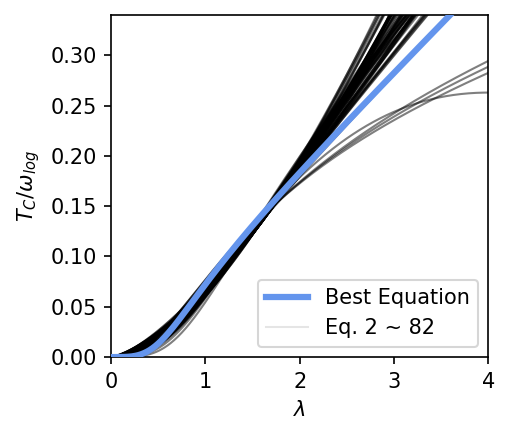

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3.5, 3), dpi=150)
for i, (expr, slope) in enumerate(zip(features_list, slope_list)):
    coeff = (slope, 0)
    
    expr = transform.format(expr)
    
    values, _ = regression.evaluate_model(expr,
                                          df_val,
                                          feature_columns,
                                          coeff)
    if i == 0:
        plt.plot(lambda_range, 
                 values, 
                 linewidth=3, 
                 color='cornflowerblue',
                 zorder=10)
    else:
        plt.plot(lambda_range, values, linewidth=1, color='k', alpha=0.5)
plt.plot([], [], linewidth=3, color='cornflowerblue', label="Best Equation")
plt.plot([], [], linewidth=1, color='k', alpha=0.1, label="Eq. 2 ~ {}".format(len(features_list)))
plt.legend(loc='lower right')
plt.xlim(0, 4)
plt.ylim(0, 0.34)
plt.xlabel("$\lambda$")
plt.ylabel("$T_C / \omega_{log}$")
plt.tight_layout()